In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import List, Tuple, Dict, Any

In [2]:
# 全局配置
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 10

# 路径配置
TMP_IF_DIR = "/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results"  # 影响力结果目录
MNIST_ROOT = "/mnt/afs/jingjinhao/project/influence_functions/mnist_data"  # MNIST数据集根目录

# 可视化配置
K_SHOW = 6  # 要展示的Helpful/Harmful样本数量
TARGET_TEST_ID = 0  # 指定要查看的测试样本ID（可修改）

In [3]:
def list_npy_test_ids(tmp_dir: str) -> List[int]:
    """
    遍历目录，获取所有one_step_train_influences_test_{id}.npy对应的test_id
    """
    test_ids = []
    for fn in os.listdir(tmp_dir):
        # 匹配one_step_train_influences_test_数字.npy格式
        m = re.match(r"one_step_train_influences_test_(\d+)\.npy$", fn)
        if m:
            test_ids.append(int(m.group(1)))
    return sorted(test_ids)

def load_one_step_influence_npy(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, float, str]:
    """
    加载指定test_id的one-step train影响力结果.npy文件
    返回：(影响力分数, 训练样本ID, 固定基准损失, 文件路径)
    """
    file_path = os.path.join(tmp_dir, f"one_step_train_influences_test_{test_id}.npy")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"影响力文件不存在：{file_path}")
    
    # 加载npy文件（保存的是字典格式）
    influence_data = np.load(file_path, allow_pickle=True).item()
    influence_scores = influence_data["influence_values"].astype(np.float32)
    train_sample_ids = influence_data["train_sample_ids"].astype(np.int64)
    fixed_base_loss = influence_data["fixed_base_loss"]
    
    print(f"成功加载：{file_path}")
    print(f"数据规模：{len(influence_scores)} 个训练样本")
    print(f"固定基准损失：{fixed_base_loss:.6f}")
    print(f"影响力分数范围：min={influence_scores.min():.6e}, mean={influence_scores.mean():.6e}, max={influence_scores.max():.6e}")
    
    return influence_scores, train_sample_ids, fixed_base_loss, file_path

def topk_helpful_harmful(scores: np.ndarray, train_ids: np.ndarray, k: int) -> Tuple[List[int], List[int]]:
    """
    获取Top-K最有帮助（正分最大）和最具破坏性（负分最小）的训练样本ID
    """
    # 按分数升序排序
    sorted_indices = np.argsort(scores)
    # 最具破坏性：前k个（分数最小，最负）
    harmful_train_ids = train_ids[sorted_indices[:k]].tolist()
    # 最有帮助：后k个并反转（分数最大，最正）
    helpful_train_ids = train_ids[sorted_indices[-k:]][::-1].tolist()
    
    return helpful_train_ids, harmful_train_ids

In [4]:
def show_influence_hist(scores: np.ndarray, test_id: int) -> None:
    """
    绘制影响力分数分布直方图
    """
    plt.figure(figsize=(9, 4))
    plt.hist(scores, bins=60, alpha=0.7, color="#1f77b4")
    plt.title(f"Influence Score Distribution (Test ID: {test_id})")
    plt.xlabel("Influence Score (base_loss - new_loss)")
    plt.ylabel("Number of Training Samples")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def show_influence_scatter_rank(scores: np.ndarray, test_id: int, k: int = 2000) -> None:
    """
    绘制影响力分数绝对值的排名散点图（避免全量绘制过慢）
    """
    n_total = scores.shape[0]
    plot_k = min(k, n_total)
    
    # 取绝对值最大的前plot_k个样本
    abs_scores = np.abs(scores)
    top_k_indices = np.argsort(abs_scores)[-plot_k:]
    top_k_abs_scores = abs_scores[top_k_indices]
    
    # 排序后绘制
    plt.figure(figsize=(9, 4))
    plt.scatter(np.arange(plot_k), np.sort(top_k_abs_scores), s=4, alpha=0.7, color="#ff7f0e")
    plt.title(f"Influence Score Absolute Value vs Rank (Test ID: {test_id}, Top {plot_k})")
    plt.xlabel("Rank (sorted by |Influence Score|)")
    plt.ylabel("|Influence Score|")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
def load_mnist_train_dataset() -> MNIST:
    """
    加载MNIST训练集（本地已有，不下载）
    """
    mnist_train = MNIST(
        root=MNIST_ROOT,
        train=True,
        download=False,
        transform=transforms.ToTensor()
    )
    print(f"\n成功加载MNIST训练集，共 {len(mnist_train)} 个样本")
    return mnist_train

def get_score_by_train_id(scores: np.ndarray, train_ids: np.ndarray, target_train_id: int) -> float:
    """
    根据训练样本ID获取对应的影响力分数
    """
    match_indices = np.where(train_ids == target_train_id)[0]
    if len(match_indices) > 0:
        return float(scores[match_indices[0]])
    return float("nan")

def show_mnist_samples(title: str, train_ids: List[int], scores: np.ndarray, all_train_ids: np.ndarray, mnist_train: MNIST, ncols: int = 6) -> None:
    """
    可视化指定训练样本的图像、标签和影响力分数
    """
    n_samples = len(train_ids)
    ncols = min(ncols, n_samples)
    nrows = int(np.ceil(n_samples / ncols))
    
    # 创建画布
    fig, axes = plt.subplots(nrows, ncols, figsize=(2.6 * ncols, 2.6 * nrows), dpi=150)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])
    
    # 设置标题
    fig.suptitle(title, y=1.02, fontsize=12)
    
    # 遍历样本绘制
    for idx, train_id in enumerate(train_ids):
        row, col = divmod(idx, ncols)
        ax = axes[row, col]
        ax.axis("off")
        
        # 获取MNIST样本（train_id即为样本索引）
        img_tensor, label = mnist_train[int(train_id)]
        img_np = img_tensor.squeeze(0).numpy()  # 去除通道维度，转为28x28数组
        
        # 获取影响力分数
        influence_score = get_score_by_train_id(scores, all_train_ids, train_id)
        
        # 绘制图像和标题
        ax.imshow(img_np, cmap="gray")
        ax.set_title(f"ID={train_id}\ny={int(label)}\nIF={influence_score:.2e}", fontsize=9)
        
        # 打印文本信息
        print(f"Train ID={train_id:6d}  Label={int(label)}  Influence Score={influence_score: .6e}")
    
    # 隐藏多余的子图
    for j in range(n_samples, nrows * ncols):
        row, col = divmod(j, ncols)
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()

def load_mnist_test_dataset() -> MNIST:
    """
    加载MNIST测试集（本地已有，不下载）
    """
    mnist_test = MNIST(
        root=MNIST_ROOT,
        train=False,
        download=False,
        transform=transforms.ToTensor()
    )
    print(f"\n成功加载MNIST测试集，共 {len(mnist_test)} 个样本")
    return mnist_test

def show_target_test_sample(test_id: int, mnist_test: MNIST, fixed_base_loss: float) -> None:
    """
    可视化目标测试样本本身的图像、标签和基准损失
    """
    # 获取测试样本
    img_tensor, label = mnist_test[int(test_id)]
    img_np = img_tensor.squeeze(0).numpy()  # 转为28x28灰度数组
    
    # 绘制图像
    plt.figure(figsize=(3, 3), dpi=150)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"Target Test Sample (ID: {test_id})\nLabel={int(label)} | Base Loss={fixed_base_loss:.6f}", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # 打印测试样本信息
    print(f"\n=== Target Test Sample Information ===")
    print(f"Test ID: {test_id}")
    print(f"Test Label: {int(label)}")
    print(f"Fixed Base Loss (on original model): {fixed_base_loss:.6f}")
    print(f"Test Image Shape: {img_np.shape} (28x28 grayscale)")
    print("=" * 50)

找到可用的测试样本ID：[0]
成功加载：/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/one_step_train_influences_test_0.npy
数据规模：55000 个训练样本
固定基准损失：0.005247
影响力分数范围：min=-3.225915e+00, mean=-1.037553e-03, max=5.155130e-03


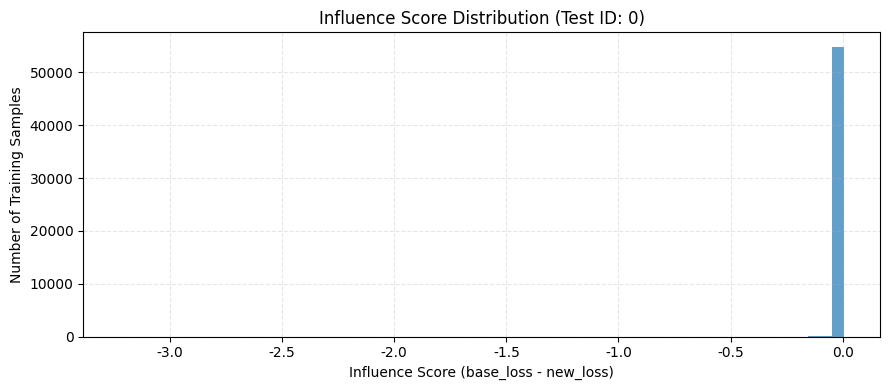

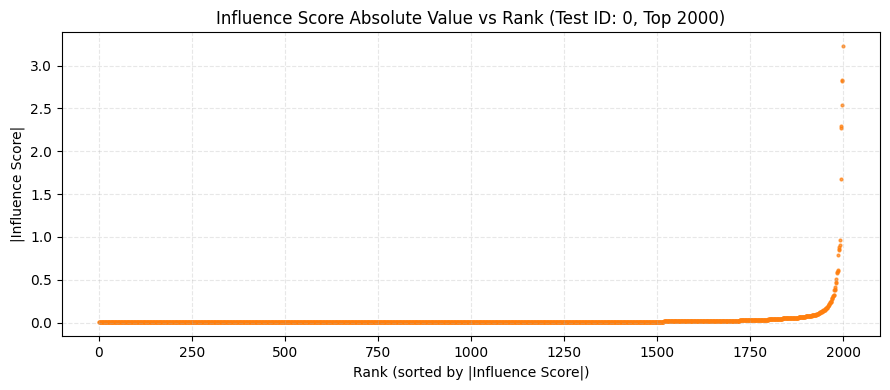


成功加载MNIST测试集，共 10000 个样本


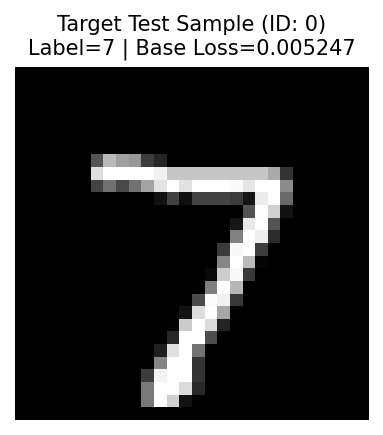


=== Target Test Sample Information ===
Test ID: 0
Test Label: 7
Fixed Base Loss (on original model): 0.005247
Test Image Shape: (28, 28) (28x28 grayscale)

成功加载MNIST训练集，共 60000 个样本

=== Helpful Samples (Most Positive Influence) ===
Train ID=  8647  Label=7  Influence Score= 5.155130e-03
Train ID= 52707  Label=7  Influence Score= 5.149647e-03
Train ID= 32738  Label=7  Influence Score= 5.114008e-03
Train ID= 17961  Label=7  Influence Score= 5.105902e-03
Train ID= 49212  Label=7  Influence Score= 5.095295e-03
Train ID= 39863  Label=7  Influence Score= 5.090527e-03


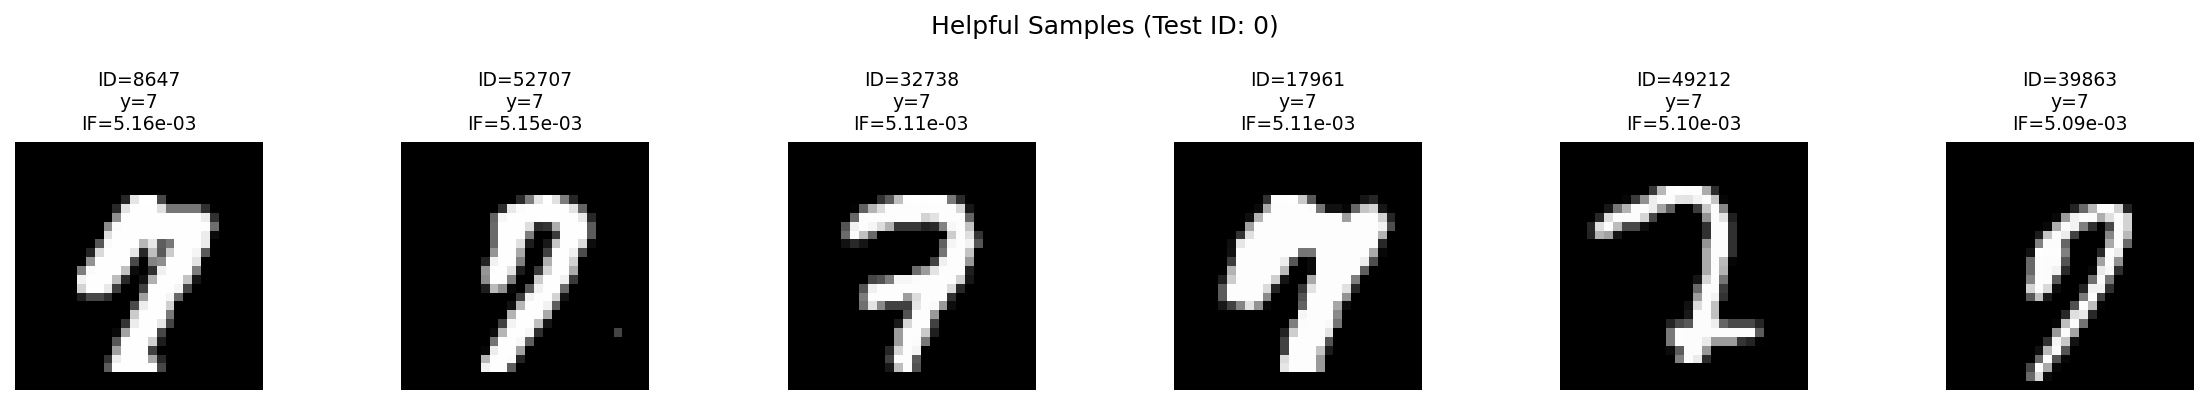


=== Harmful Samples (Most Negative Influence) ===
Train ID= 39184  Label=3  Influence Score=-3.225915e+00
Train ID=  8729  Label=3  Influence Score=-2.827384e+00
Train ID=  2098  Label=3  Influence Score=-2.816107e+00
Train ID= 36104  Label=9  Influence Score=-2.534500e+00
Train ID= 39327  Label=3  Influence Score=-2.290056e+00
Train ID=  4762  Label=3  Influence Score=-2.268611e+00


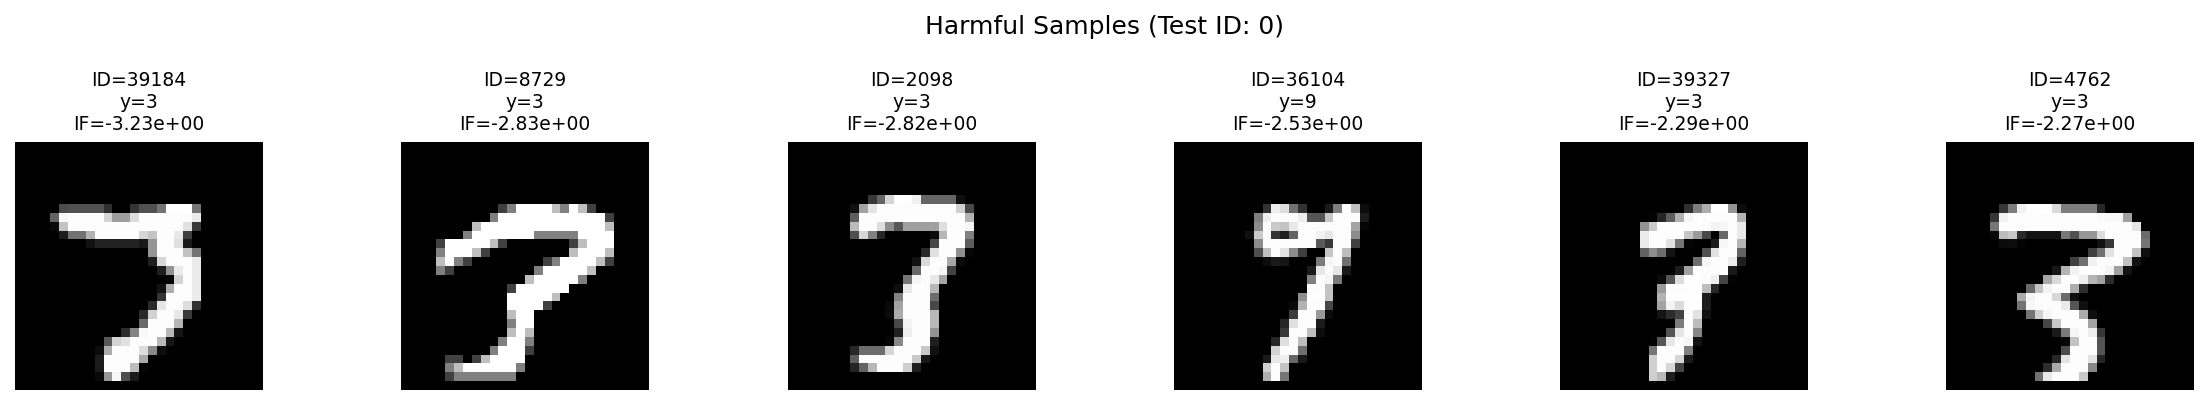

In [6]:
def main():
    # 1. 列出所有可用的test_id
    available_test_ids = list_npy_test_ids(TMP_IF_DIR)
    if not available_test_ids:
        print(f"在目录 {TMP_IF_DIR} 中未找到one_step_train_influences_test_*.npy文件")
        return
    print(f"找到可用的测试样本ID：{available_test_ids}")
    
    # 2. 验证目标test_id是否存在
    target_test_id = TARGET_TEST_ID
    if target_test_id not in available_test_ids:
        print(f"指定的Test ID {target_test_id} 不存在，默认使用第一个ID：{available_test_ids[0]}")
        target_test_id = available_test_ids[0]
    
    # 3. 加载影响力数据
    influence_scores, train_sample_ids, fixed_base_loss, file_path = load_one_step_influence_npy(
        tmp_dir=TMP_IF_DIR,
        test_id=target_test_id
    )
    
    # 4. 绘制统计图表
    show_influence_hist(influence_scores, target_test_id)
    show_influence_scatter_rank(influence_scores, target_test_id)
    
    # 5. 加载MNIST测试集并可视化目标测试样本（新增步骤）
    mnist_test = load_mnist_test_dataset()
    show_target_test_sample(target_test_id, mnist_test, fixed_base_loss)
    
    # 6. 获取Top-K Helpful和Harmful样本ID
    helpful_ids, harmful_ids = topk_helpful_harmful(influence_scores, train_sample_ids, K_SHOW)
    
    # 7. 加载MNIST训练集
    mnist_train = load_mnist_train_dataset()
    
    # 8. 可视化Helpful样本
    print("\n=== Helpful Samples (Most Positive Influence) ===")
    show_mnist_samples(
        title=f"Helpful Samples (Test ID: {target_test_id})",
        train_ids=helpful_ids,
        scores=influence_scores,
        all_train_ids=train_sample_ids,
        mnist_train=mnist_train,
        ncols=K_SHOW
    )
    
    # 9. 可视化Harmful样本
    print("\n=== Harmful Samples (Most Negative Influence) ===")
    show_mnist_samples(
        title=f"Harmful Samples (Test ID: {target_test_id})",
        train_ids=harmful_ids,
        scores=influence_scores,
        all_train_ids=train_sample_ids,
        mnist_train=mnist_train,
        ncols=K_SHOW
    )

# 执行主函数
if __name__ == "__main__":
    main()

Successfully loaded NPY file: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/one_step_train_influences_test_0.npy
NPY data shape: influence_values=(55000,), train_sample_ids=(55000,)
Successfully loaded NPZ file: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/influences_test_0.npz
NPZ data shape: scores=(55000,), train_ids=(55000,)

=== Detailed Data Statistics ===
NPY File: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/one_step_train_influences_test_0.npy
  - Train ID count: 55,000 (shape: (55000,))
  - Influence score count: 55,000 (shape: (55000,))
  - Fixed base loss: 0.005247
NPZ File: /mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results/influences_test_0.npz
  - Train ID count: 55,000 (shape: (55000,))
  - Influence score count: 55,000 (shape: (55000,))
  - Data types: scores=float64, train_ids=int64
Data count difference: 0 samples
[Info] IDs are fully overlapping, comm

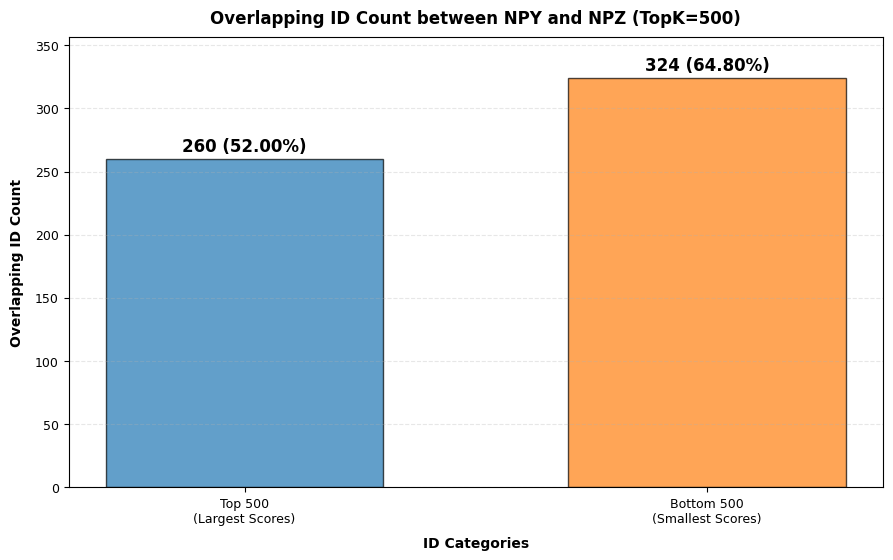


=== NPY and NPZ Influence File Comparison Completed ===


In [25]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from scipy.stats import spearmanr

# -------------------------- 全局配置 --------------------------
# 路径配置
TMP_IF_DIR = "/mnt/afs/jingjinhao/project/influence_functions/mnist_experiment/if_results"
TARGET_TEST_ID = 0
# 可视化配置（优化字体和样式，避免超出边框）
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 9  # 减小全局字体大小
plt.rcParams["axes.titlepad"] = 10  # 标题间距
plt.rcParams["axes.labelpad"] = 8  # 坐标轴标签间距
# 自定义TopK值（可修改为你需要的数值，如10/30/50/10000）
CUSTOM_TOPK = 10000  # 按需调整

# -------------------------- 数据加载函数 --------------------------
def load_influence_npz(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, str]:
    """
    Load influences_test_{id}.npz file (55000 full samples)
    Returns: (influence_scores, train_sample_ids, file_path)
    """
    npz_path = os.path.join(tmp_dir, f"influences_test_{test_id}.npz")
    if not os.path.exists(npz_path):
        raise FileNotFoundError(f"NPZ influence file not found: {npz_path}")
    
    npz_data = np.load(npz_path)
    scores = npz_data["scores"]
    train_ids = npz_data["train_ids"]
    
    print(f"Successfully loaded NPZ file: {npz_path}")
    print(f"NPZ data shape: scores={scores.shape}, train_ids={train_ids.shape}")
    return scores, train_ids, npz_path

def load_one_step_influence_npy(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, float, str]:
    """
    Load one_step_train_influences_test_{id}.npy file (full samples)
    Returns: (influence_scores, train_sample_ids, fixed_base_loss, file_path)
    """
    npy_path = os.path.join(tmp_dir, f"one_step_train_influences_test_{test_id}.npy")
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"NPY influence file not found: {npy_path}")
    
    influence_data = np.load(npy_path, allow_pickle=True).item()
    influence_scores = influence_data["influence_values"]
    train_sample_ids = influence_data["train_sample_ids"]
    fixed_base_loss = influence_data["fixed_base_loss"]
    
    print(f"Successfully loaded NPY file: {npy_path}")
    print(f"NPY data shape: influence_values={influence_scores.shape}, train_sample_ids={train_sample_ids.shape}")
    return influence_scores, train_sample_ids, fixed_base_loss, npy_path

def list_npy_test_ids(tmp_dir: str) -> List[int]:
    """
    List all available test IDs from one_step_train_influences_test_*.npy files
    """
    test_ids = []
    for fn in os.listdir(tmp_dir):
        m = re.match(r"one_step_train_influences_test_(\d+)\.npy$", fn)
        if m:
            test_ids.append(int(m.group(1)))
    return sorted(test_ids)

# -------------------------- 排序一致性验证函数 --------------------------
def calculate_id_rank_consistency(npy_scores: np.ndarray, npy_train_ids: np.ndarray, 
                                  npz_scores: np.ndarray, npz_train_ids: np.ndarray) -> float:
    """
    Verify ID ranking consistency between NPY and NPZ (Spearman's rank correlation)
    Returns: Correlation coefficient (0~1)
    """
    common_train_ids = np.intersect1d(npy_train_ids, npz_train_ids)
    if len(common_train_ids) == 0:
        print("[Warning] No common train IDs between the two files, cannot verify ranking consistency")
        return 0.0
    elif len(common_train_ids) != len(npy_train_ids) or len(common_train_ids) != len(npz_train_ids):
        print(f"[Info] IDs are not fully overlapping: NPY={len(npy_train_ids)}, NPZ={len(npz_train_ids)}, Common={len(common_train_ids)}")
    else:
        print(f"[Info] IDs are fully overlapping, common ID count: {len(common_train_ids)}")
    
    def get_rank_map(scores: np.ndarray, train_ids: np.ndarray) -> Dict[int, int]:
        sorted_indices = np.argsort(scores)[::-1]
        sorted_train_ids = train_ids[sorted_indices]
        return {tid: rank for rank, tid in enumerate(sorted_train_ids, start=1)}
    
    npy_rank_map = get_rank_map(npy_scores, npy_train_ids)
    npz_rank_map = get_rank_map(npz_scores, npz_train_ids)
    
    npy_ranks = [npy_rank_map[tid] for tid in common_train_ids]
    npz_ranks = [npz_rank_map[tid] for tid in common_train_ids]
    
    corr_coef, p_value = spearmanr(npy_ranks, npz_ranks)
    print(f"\n=== Ranking Consistency Verification ===")
    print(f"Spearman's Rank Correlation Coefficient: {corr_coef:.4f} (p-value: {p_value:.6f})")
    print(f"Note: Coefficient closer to 1 means higher ranking consistency; <0 means reverse ranking")
    return corr_coef

# -------------------------- TopK重合概率计算函数（返回重合数和百分比） --------------------------
def calculate_topk_overlap_count_and_prob(npy_train_ids: np.ndarray, npz_train_ids: np.ndarray, 
                                          npy_scores: np.ndarray, npz_scores: np.ndarray,
                                          topk: int, is_ascending: bool = False) -> Tuple[int, float]:
    """
    Calculate overlapping ID count and probability for TopK (or bottom TopK)
    :param is_ascending: True=bottom TopK (smallest scores), False=top TopK (largest scores)
    :return: (Overlapping ID count, Overlap probability)
    """
    # Sort NPY data and get TopK IDs
    npy_sorted_indices = np.argsort(npy_scores)
    if not is_ascending:
        npy_sorted_indices = npy_sorted_indices[::-1]
    npy_topk_ids = set(npy_train_ids[npy_sorted_indices[:topk]])
    
    # Sort NPZ data and get TopK IDs
    npz_sorted_indices = np.argsort(npz_scores)
    if not is_ascending:
        npz_sorted_indices = npz_sorted_indices[::-1]
    npz_topk_ids = set(npz_train_ids[npz_sorted_indices[:topk]])
    
    # Calculate overlap
    overlap_ids = npy_topk_ids & npz_topk_ids
    overlap_count = len(overlap_ids)
    overlap_prob = overlap_count / topk if topk > 0 else 0.0
    
    # Print details
    tag = "Top TopK (Largest Scores)" if not is_ascending else "Bottom TopK (Smallest Scores)"
    print(f"\n=== {tag} ID Overlap (TopK={topk}) ===")
    print(f"NPY {tag} ID count: {len(npy_topk_ids)} (actual {topk} samples)")
    print(f"NPZ {tag} ID count: {len(npz_topk_ids)} (actual {topk} samples)")
    print(f"Overlapping ID count: {overlap_count}")
    print(f"Overlap probability: {overlap_prob:.4f} ({overlap_count}/{topk})")
    if overlap_count > 0:
        print(f"Overlapping ID list: {sorted(list(overlap_ids))[:10]}...")
    
    return overlap_count, overlap_prob

# -------------------------- 直方图可视化函数（数字+百分比合并显示，无重叠） --------------------------
def plot_topk_overlap_histogram(topk: int, top_overlap_count: int, top_overlap_prob: float,
                                bottom_overlap_count: int, bottom_overlap_prob: float) -> None:
    """
    Plot histogram for TopK and Bottom TopK overlapping counts (count + percentage in one line)
    Optimized for scale, no longer out of bounds
    """
    # Data preparation
    # 优化类别标签：分行显示，避免过长
    top_label = f"Top {topk}\n(Largest Scores)"
    bottom_label = f"Bottom {topk}\n(Smallest Scores)"
    categories = [top_label, bottom_label]
    overlap_counts = [top_overlap_count, bottom_overlap_count]
    overlap_probs = [top_overlap_prob, bottom_overlap_prob]
    colors = ["#1f77b4", "#ff7f0e"]
    
    # 动态调整图表尺寸：根据TopK大小适配宽度
    fig_width = 12 if topk >= 1000 else 9  # 大TopK进一步增大宽度，避免文字挤压
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    # Plot bar chart：调整柱子宽度，避免过宽/过窄
    bar_width = 0.6 if len(categories) == 2 else 0.5
    bars = ax.bar(categories, overlap_counts, width=bar_width, color=colors, alpha=0.7, edgecolor="black", linewidth=1)
    
    # Add merged labels (count + percentage) on top of bars：合并显示，避免重叠
    label_fontsize = 10 if topk >= 1000 else 12  # 大TopK减小标签字体
    y_offset = max(overlap_counts) * 0.01 if max(overlap_counts) > 0 else 0.5  # 动态偏移，避免超出
    for bar, count, prob in zip(bars, overlap_counts, overlap_probs):
        height = bar.get_height()
        # 合并显示数量和百分比（同一行）
        label_text = f"{count:,} ({prob:.2%})"
        ax.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                label_text,
                ha="center", va="bottom", fontsize=label_fontsize, fontweight="bold")
    
    # Set labels and title：优化字体大小
    ax.set_xlabel("ID Categories", fontsize=10, fontweight="bold")
    ax.set_ylabel("Overlapping ID Count", fontsize=10, fontweight="bold")
    ax.set_title(f"Overlapping ID Count between NPY and NPZ (TopK={topk:,})", fontsize=12, fontweight="bold")
    
    # Set y-axis limit：动态调整y轴范围，避免标签超出
    y_max = max(overlap_counts) * 1.1 if max(overlap_counts) > 0 else 10
    ax.set_ylim(0, y_max)
    
    # Add grid：仅显示y轴网格，更整洁
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    
    # 优化x轴标签显示：自动旋转（如需）
    ax.tick_params(axis="x", labelsize=9, rotation=0)  # 无需旋转，已分行显示
    
    # 强制调整布局，解决边框溢出
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)  # 手动调整上下边距
    
    # Show plot
    plt.show()

# -------------------------- 主对比函数 --------------------------
def compare_npy_and_npz_influence(tmp_dir: str, test_id: int, custom_topk: int) -> None:
    """
    Main function for comparing NPY and NPZ influence files
    """
    try:
        # 1. Load data
        npy_scores, npy_train_ids, npy_base_loss, npy_path = load_one_step_influence_npy(tmp_dir, test_id)
        npz_scores, npz_train_ids, npz_path = load_influence_npz(tmp_dir, test_id)
        
        # 2. Detailed data statistics
        print(f"\n=== Detailed Data Statistics ===")
        print(f"NPY File: {npy_path}")
        print(f"  - Train ID count: {len(npy_train_ids):,} (shape: {npy_train_ids.shape})")
        print(f"  - Influence score count: {len(npy_scores):,} (shape: {npy_scores.shape})")
        print(f"  - Fixed base loss: {npy_base_loss:.6f}")
        print(f"NPZ File: {npz_path}")
        print(f"  - Train ID count: {len(npz_train_ids):,} (shape: {npz_train_ids.shape})")
        print(f"  - Influence score count: {len(npz_scores):,} (shape: {npz_scores.shape})")
        print(f"  - Data types: scores={npz_scores.dtype}, train_ids={npz_train_ids.dtype}")
        print(f"Data count difference: {len(npy_train_ids) - len(npz_train_ids):,} samples")
        
        # 3. Verify ranking consistency
        calculate_id_rank_consistency(npy_scores, npy_train_ids, npz_scores, npz_train_ids)
        
        # 4. Calculate TopK overlap counts and probabilities
        top_overlap_count, top_overlap_prob = calculate_topk_overlap_count_and_prob(npy_train_ids, npz_train_ids, 
                                                                                   npy_scores, npz_scores, custom_topk, is_ascending=False)
        bottom_overlap_count, bottom_overlap_prob = calculate_topk_overlap_count_and_prob(npy_train_ids, npz_train_ids, 
                                                                                          npy_scores, npz_scores, custom_topk, is_ascending=True)
        
        # 5. Plot histogram (merged count + percentage)
        plot_topk_overlap_histogram(custom_topk, top_overlap_count, top_overlap_prob,
                                    bottom_overlap_count, bottom_overlap_prob)
        
        print(f"\n=== NPY and NPZ Influence File Comparison Completed ===")
        
    except Exception as e:
        print(f"[Error] Comparison failed: {str(e)}")

# -------------------------- 执行对比 --------------------------
if __name__ == "__main__":
    # Verify target test ID validity
    available_test_ids = list_npy_test_ids(TMP_IF_DIR)
    target_test_id = TARGET_TEST_ID
    
    if not available_test_ids:
        print(f"No one_step_train_influences_test_*.npy files found in {TMP_IF_DIR}")
    else:
        if target_test_id not in available_test_ids:
            print(f"Specified Test ID {target_test_id} not found, using first ID: {available_test_ids[0]}")
            target_test_id = available_test_ids[0]
        
        CUSTOM_TOPK = 500
        # Execute comparison
        compare_npy_and_npz_influence(TMP_IF_DIR, target_test_id, CUSTOM_TOPK)